[SIN_RUIDO] T=3  LZ sin corregir : {'0': 0.66788, '1': 0.33212}
[SIN_RUIDO] T=3  LZ corregido    : {'1': 0.25758, '0': 0.74242}
[SIN_RUIDO] T=3  LX sin corregir : {'0': 0.5008, '1': 0.4992}
[SIN_RUIDO] T=3  LX corregido    : {'0': 0.50116, '1': 0.49884}


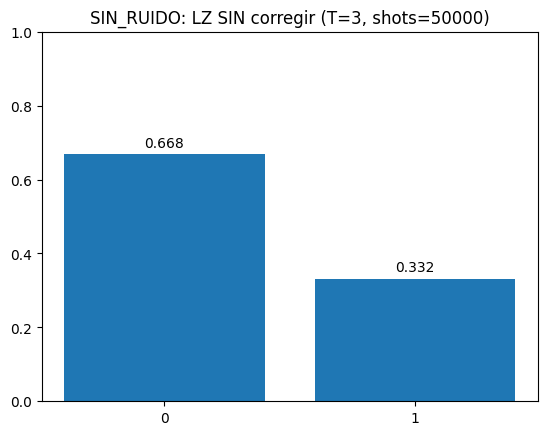

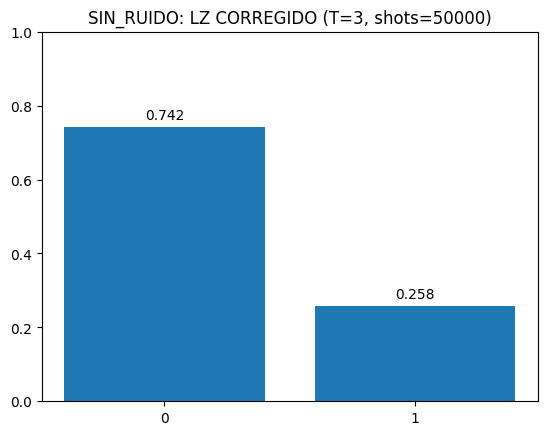

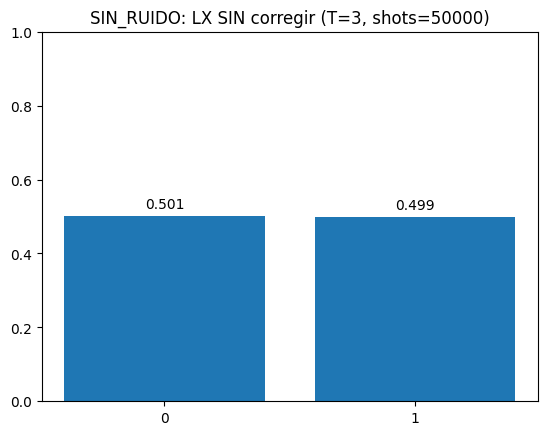

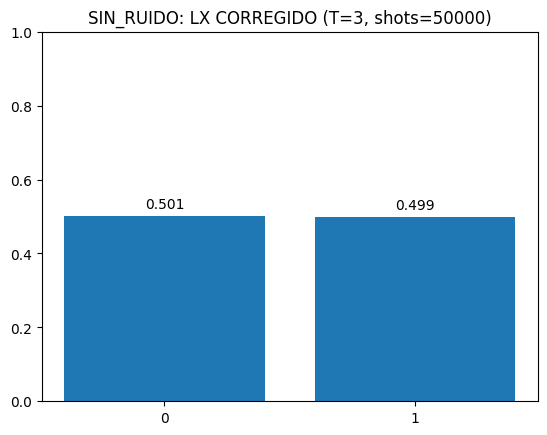

Tiempo total: 169.50s


In [7]:
# -*- coding: utf-8 -*-
# Surface code d=3 con T>1 (mínimo, didáctico) + preparación lógica 66/33
#   pip install "qiskit>=2.1" "qiskit-aer>=0.14" "qiskit-ibm-runtime" matplotlib

import os, math, time
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.primitives import BackendSamplerV2
from qiskit_ibm_runtime.fake_provider import FakeTorino

# ===================== Parámetros =====================
SHOTS        = 50_000
SEED_SIM     = 1234
T_RONDAS     = 3          # >=2 para filtrar errores de medida
RESETS       = True       # reset de ancillas entre rondas

# Preparación lógica opcional (para 66/33)
PREP_LOGICAL = True
THETA        = 2*np.arccos(np.sqrt(2/3))  # -> P(0)=2/3 al medir LZ si aplicas Rx^L(THETA)

# Ruido (solo si CON_RUIDO)
P1 = 3e-4               # 1q depolarizing
P2 = 3e-3               # 2q depolarizing
PM = 1e-2               # readout

# Inyección opcional de error físico antes de síndromes
INJECT_ERROR = None     # None | ('X'|'Z'|'Y', qubit_id 0..8)

GRAFICAR     = "SIN_RUIDO"   # "SIN_RUIDO" | "CON_RUIDO" | "FAKE_TORINO"

# ===================== Malla d=3 y estabilizadores =====================
# Datos (3x3):
#  0 1 2
#  3 4 5
#  6 7 8
DATA = list(range(9))

# Plaquetas (cuadrados 2x2):
SQUARES = [
    [0,1,4,3],  # s00
    [1,2,5,4],  # s01
    [3,4,7,6],  # s10
    [4,5,8,7],  # s11
]
Z_CHECKS = [list(s) for s in SQUARES]  # detectan X
X_CHECKS = [list(s) for s in SQUARES]  # detectan Z

# Patrones (síndrome -> qubit) para errores de peso-1
ADJ_Z = {  # X en q -> checks Z activados
    0:[0], 1:[0,1], 2:[1], 3:[0,2], 4:[0,1,2,3], 5:[1,3], 6:[2], 7:[2,3], 8:[3]
}
ADJ_X = ADJ_Z.copy()    # misma geometría para Z en q -> checks X activados

# ===================== Ruido =====================
def build_noise_model(p1, p2, pm) -> NoiseModel:
    noise = NoiseModel()
    noise.add_all_qubit_quantum_error(depolarizing_error(p1, 1),
        ['x','y','z','h','s','sdg','t','tdg','rx','ry','rz','sx'])
    noise.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])
    ro = ReadoutError([[1-pm, pm],[pm,1-pm]])
    noise.add_all_qubit_readout_error(ro)
    return noise

# ===================== Bloques de medida =====================
def measure_z_check(qc: QuantumCircuit, data, anc):
    for q in data:
        qc.cx(q, anc)

def measure_x_check(qc: QuantumCircuit, data, anc):
    for q in data:
        qc.h(q); qc.cx(q, anc); qc.h(q)

# ===================== Construcción de circuitos =====================
def build_surface_d3(T=1, resets=True, readout='Z', inject_error=None, logical_prep=None) -> QuantumCircuit:
    """
    readout='Z': mide SÓLO Z-checks y luego lee datos en Z -> LZ (corrige X)
    readout='X': mide SÓLO X-checks y luego H+lee en Z -> LX (corrige Z)
    logical_prep: None | ('RX', theta) | ('RZ', theta)
      - ('RX',theta) aplica Rx^L(theta) en {0,3,6} (opera sobre X_L)
      - ('RZ',theta) aplica Rz^L(theta) en {0,1,2} (opera sobre Z_L)
    """
    q_data = QuantumRegister(9, 'd')
    aZ     = QuantumRegister(4, 'aZ')           # 4 ancillas Z reutilizadas
    aX     = QuantumRegister(4, 'aX')           # 4 ancillas X reutilizadas
    cZ     = ClassicalRegister(4*T, 'cZ')       # T rondas * 4 checks
    cX     = ClassicalRegister(4*T, 'cX')
    cDATA  = ClassicalRegister(9, 'cD')
    qc = QuantumCircuit(q_data, aZ, aX, cZ, cX, cDATA, name=f'surface_d3_T{T}_{readout}')

    # Preparación (|0>^9)
    qc.barrier(label="prep")

    # Inyección de error físico (opcional)
    if inject_error is not None:
        etype, pos = inject_error
        if etype.upper()=='X': qc.x(q_data[pos])
        elif etype.upper()=='Z': qc.z(q_data[pos])
        elif etype.upper()=='Y': qc.y(q_data[pos])

    # Preparación lógica opcional
    if logical_prep is not None:
        gate, theta = logical_prep
        if gate.upper() == 'RX':   # X lógico sobre {0,3,6}
            for q in [0,3,6]:
                qc.rx(theta, q_data[q])
        elif gate.upper() == 'RZ': # Z lógico sobre {0,1,2}
            for q in [0,1,2]:
                qc.rz(theta, q_data[q])

    qc.barrier(label="syndrome")

    # T rondas (sólo del tipo necesario para el readout)
    for t in range(T):
        if readout.upper() == 'Z':
            # Z-checks (detectan X) -> necesarios para LZ
            for i, s in enumerate(Z_CHECKS):
                measure_z_check(qc, [q_data[k] for k in s], aZ[i])
                qc.measure(aZ[i], cZ[t*4 + i])
                if resets: qc.reset(aZ[i])

        if readout.upper() == 'X':
            # X-checks (detectan Z) -> necesarios para LX
            for i, s in enumerate(X_CHECKS):
                measure_x_check(qc, [q_data[k] for k in s], aX[i])
                qc.measure(aX[i], cX[t*4 + i])
                if resets: qc.reset(aX[i])

        if t < T-1:
            qc.barrier(label=f"round_{t+1}")

    qc.barrier(label="readout")

    # Readout lógico
    if readout.upper() == 'X':
        # medir en X ≡ H a todos y medir en Z
        for q in DATA: qc.h(q_data[q])
    for i in range(9):
        qc.measure(q_data[i], cDATA[i])

    return qc

# ===================== Sampler y parseo =====================
def run_sampler(circ: QuantumCircuit, backend, shots: int) -> Counter:
    sampler = BackendSamplerV2(backend=backend)
    res = sampler.run([circ], shots=shots).result()[0]
    return Counter(res.join_data().get_counts())

def _bits_of_register(circ: QuantumCircuit, key: str, creg: ClassicalRegister):
    bits = ''.join(ch for ch in key if ch in '01')
    out = []
    for bit in creg:
        idx = circ.clbits.index(bit)
        out.append(bits[-1 - idx])
    return out

def parse_counts_T(circ: QuantumCircuit, counts: Counter, T: int):
    name2reg = {reg.name: reg for reg in circ.cregs}
    regZ = name2reg['cZ']; regX = name2reg['cX']; regD = name2reg['cD']
    parsed = []
    for k, c in counts.items():
        z_all = list(map(int, _bits_of_register(circ, k, regZ)))  # len=4T (si no mediste Z-checks, serán 0s)
        x_all = list(map(int, _bits_of_register(circ, k, regX)))  # len=4T (análogo)
        d_bits= list(map(int, _bits_of_register(circ, k, regD)))  # len=9
        z_rounds = [z_all[t*4:(t+1)*4] for t in range(T)]
        x_rounds = [x_all[t*4:(t+1)*4] for t in range(T)]
        parsed.append((k, c, z_rounds, x_rounds, d_bits))
    return parsed

# ===================== Decodificador (peso-1 + mayoría temporal) =====================
def majority_per_check(rounds_bits):
    """
    rounds_bits: lista de T listas de 4 bits (checks).
    Devuelve 4 bits por consenso (>= mitad -> 1).
    """
    if not rounds_bits:
        return [0,0,0,0]
    T = len(rounds_bits)
    cols = list(zip(*rounds_bits))  # 4 tuplas de longitud T
    return [1 if sum(col)*2 >= T else 0 for col in cols]

def syndrome_to_qubit(syn_bits, adj_map):
    if not any(syn_bits):
        return None
    target = set(i for i,b in enumerate(syn_bits) if b==1)
    # match exacto
    for q, checks in adj_map.items():
        if set(checks)==target:
            return q
    # fallback: mínima distancia de Hamming
    best_q, best_dist = None, 1e9
    for q, checks in adj_map.items():
        dist = len(target.symmetric_difference(set(checks)))
        if dist < best_dist:
            best_dist = dist; best_q = q
    return best_q

def logical_Z_from_data_bits(d_bits):
    # LZ: paridad Z de (0,1,2)
    return (d_bits[0] ^ d_bits[1] ^ d_bits[2]) & 1

def logical_X_from_data_bits(d_bits):
    # LX: paridad X de (0,3,6) (ya estamos midiendo en base-X en el circuito 'X')
    return (d_bits[0] ^ d_bits[3] ^ d_bits[6]) & 1

def corrected_LZ(z_consensus_bits, d_bits):
    qx = syndrome_to_qubit(z_consensus_bits, ADJ_Z)  # sospechoso X
    Lraw = logical_Z_from_data_bits(d_bits)
    if qx is None:
        return Lraw
    return Lraw ^ 1 if qx in (0,1,2) else Lraw

def corrected_LX(x_consensus_bits, d_bits):
    qz = syndrome_to_qubit(x_consensus_bits, ADJ_X)  # sospechoso Z
    Lraw = logical_X_from_data_bits(d_bits)
    if qz is None:
        return Lraw
    return Lraw ^ 1 if qz in (0,3,6) else Lraw

# ===================== Plot =====================
def plot_bar(probs: dict, title: str):
    # Asegura claves '0' y '1' siempre presentes
    probs = {'0': probs.get('0',0.0), '1': probs.get('1',0.0)}
    plt.bar(list(probs.keys()), list(probs.values()))
    plt.ylim(0, 1)
    for x,v in probs.items():
        plt.text(x, min(1.0, v+0.02), f"{v:.3f}", ha='center')
    plt.title(title); plt.show()

# ===================== Ejecución por modo/lectura =====================
def run_mode(backend, T, readout, inject_error, logical_prep):
    qc = build_surface_d3(T=T, resets=RESETS, readout=readout,
                          inject_error=inject_error, logical_prep=logical_prep)
    qc_t = transpile(qc, backend, optimization_level=3, seed_transpiler=SEED_SIM)
    counts = run_sampler(qc_t, backend, SHOTS)

    raw_counter = Counter()
    cor_counter = Counter()

    for k, c, z_rounds, x_rounds, d_bits in parse_counts_T(qc_t, counts, T):
        # Consenso según el tipo de readout
        if readout.upper()=='Z':
            z_cons = majority_per_check(z_rounds)   # corrige X
            Lraw = logical_Z_from_data_bits(d_bits)
            Lcor = corrected_LZ(z_cons, d_bits)
        else:
            x_cons = majority_per_check(x_rounds)   # corrige Z
            Lraw = logical_X_from_data_bits(d_bits)
            Lcor = corrected_LX(x_cons, d_bits)

        raw_counter[str(Lraw)] += c
        cor_counter[str(Lcor)] += c

    tot = sum(raw_counter.values())
    raw_probs = {k: v/tot for k,v in raw_counter.items()}
    cor_probs = {k: v/tot for k,v in cor_counter.items()}
    return raw_probs, cor_probs

# ===================== Main =====================
def main(graficar: str, T=T_RONDAS, inject_error=INJECT_ERROR, prep_logical=PREP_LOGICAL):
    n_threads = max(1, math.floor(os.cpu_count() / 3))

    if graficar == "SIN_RUIDO":
        backend = AerSimulator(method="automatic", seed_simulator=SEED_SIM)
    elif graficar == "CON_RUIDO":
        noise = build_noise_model(P1, P2, PM)
        backend = AerSimulator(method="automatic", noise_model=noise, seed_simulator=SEED_SIM)
    elif graficar == "FAKE_TORINO":
        fake = FakeTorino()
        backend = AerSimulator.from_backend(fake, seed_simulator=SEED_SIM)
    else:
        raise ValueError("graficar debe ser 'SIN_RUIDO', 'CON_RUIDO' o 'FAKE_TORINO'.")

    backend.set_options(max_parallel_threads=n_threads,
                        max_parallel_experiments=n_threads,
                        fusion_enable=True, blocking_enable=True)

    # Preparaciones lógicas para cada lectura (si se desea 66/33)
    lp_Z = ('RX', THETA) if prep_logical else None   # afecta LZ
    lp_X = ('RZ', THETA) if prep_logical else None   # afecta LX

    # Ejecuta dos lecturas: LZ (corrige X) y LX (corrige Z)
    rawZ, corZ = run_mode(backend, T, readout='Z', inject_error=inject_error, logical_prep=lp_Z)
    rawX, corX = run_mode(backend, T, readout='X', inject_error=inject_error, logical_prep=lp_X)

    print(f"[{graficar}] T={T}  LZ sin corregir :", rawZ)
    print(f"[{graficar}] T={T}  LZ corregido    :", corZ)
    print(f"[{graficar}] T={T}  LX sin corregir :", rawX)
    print(f"[{graficar}] T={T}  LX corregido    :", corX)

    plot_bar(rawZ, f"{graficar}: LZ SIN corregir (T={T}, shots={SHOTS})")
    plot_bar(corZ, f"{graficar}: LZ CORREGIDO (T={T}, shots={SHOTS})")
    plot_bar(rawX, f"{graficar}: LX SIN corregir (T={T}, shots={SHOTS})")
    plot_bar(corX, f"{graficar}: LX CORREGIDO (T={T}, shots={SHOTS})")

if __name__ == "__main__":
    t0 = time.time()
    # Ejemplos:
    #   PREP_LOGICAL=True  -> verás ~66/33 en LZ (y en LX si activas RZ lógico)
    #   INJECT_ERROR = None
    #   INJECT_ERROR = ('X', 1)   # afecta LZ (fila superior)
    #   INJECT_ERROR = ('Z', 3)   # afecta LX (columna izquierda)
    #   INJECT_ERROR = ('Y', 4)   # afecta a ambos (X y Z)
    main(GRAFICAR, T=T_RONDAS, inject_error=INJECT_ERROR, prep_logical=PREP_LOGICAL)
    print(f"Tiempo total: {time.time() - t0:.2f}s")
